# LAB 1

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from scipy.optimize import root as get_root
from sklearn.cluster import DBSCAN, KMeans
from numba import njit
from sympy import *

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100

# Task 1

In [300]:
interval = (2.8, 4)  # start, end
accuracy = 0.00001
reps = 1000  # number of repetitions
a = 1e-2
alpha_theory = 2.502907

R = np.arange(*interval, accuracy)
R = interval[0] + np.cumsum(np.diff(R)[0] * alpha_theory**(-np.linspace(0, 1, len(R))))

lims = []
lims2 = [] # initialize for the plot with perturbations

def perturbation(x):
    return a*x**4

for n, r in tqdm(enumerate(R)):
    temp_lims = []
    temp_lims2 = [] # initialize temp lists for storing data
    initial_val = np.random.rand()
    temp_lims.append(initial_val)
#    temp_lims2.append(initial_val + perturbation(initial_val)) # creating the same initial condition as the perturbed version
    
    for i in range(reps-1):
        val = r*temp_lims[i]*(1-temp_lims[i])
        temp_lims.append(val)
#        temp_lims2.append(val + perturbation(val)) # store values with perturbation
    
    lims.append(temp_lims)
#    lims2.append(temp_lims2) # store temp lists in main lists
    
lims = np.array(lims)
#lims2 = np.array(lims2)

120001it [01:23, 1443.38it/s]


More optimized plotting

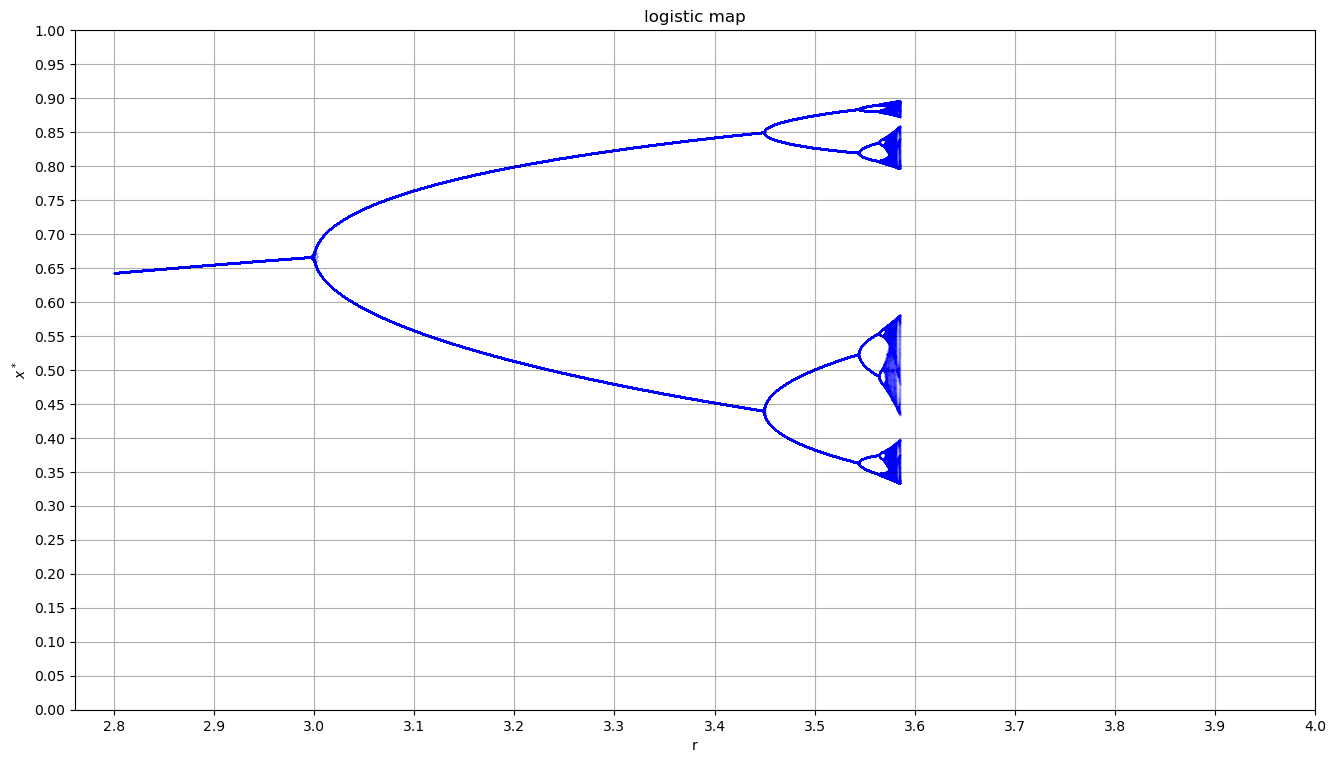

In [301]:
numtoplot = 50

fig, biax = plt.subplots(figsize=(16, 9))

# create arrays of x-coordinates and y-coordinates for unperturbed data
r_vals = R#np.arange(*interval, accuracy)
x_vals = lims[:, -numtoplot:]
r_broadcasted = np.broadcast_to(r_vals[:, None], (len(r_vals), numtoplot))
biax.plot(r_broadcasted.flatten(), x_vals.flatten(), 'b.', markersize=.02)

# create arrays of x-coordinates and y-coordinates for perturbed data
#x2_vals = lims2[:, -numtoplot:]
#biax.plot(r_broadcasted.flatten(), x2_vals.flatten(), 'r.', markersize=.02)

biax.set(xlabel='r', ylabel='$x^*$', title='logistic map')
plt.xticks(np.arange(*interval, 0.1))
plt.yticks(np.arange(0, 1+0.05, 0.05))
plt.grid()
#plt.legend()
#plt.show()
#plt.savefig("logistic map (blue) - perturbed map (red)", bbox_inches="tight")

# Task 2
Compute the Feigenbaum constants $\alpha\approx 2.5029$ and $\beta\approx4.6692$
for both maps.

## Finding the Lyapunov exponent

In [302]:
def diff(x, r): # Derivative of the Logistic map 
    return r*(1 - 2*x)

# bifurcation parameters
L = []

for i in tqdm(range(len(R))):
    # Finding the x for different iterations x_i=(x1, x2, ..., xn)_i
    x = lims[i] 
    r = R[i]
    # Computing the Lyapunov exponent for some different bifurcation parameters
    L.append(np.log(np.abs(diff(x, r))).mean())

L = np.array(L)

100%|██████████| 120001/120001 [00:04<00:00, 24916.11it/s]


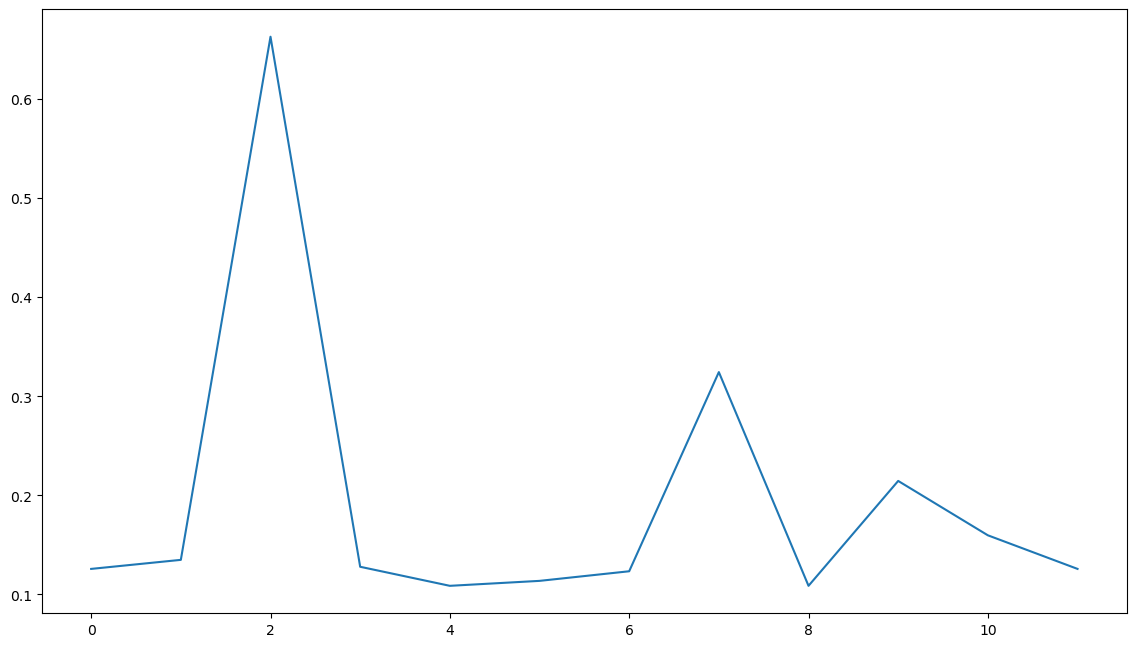

In [315]:
from scipy.signal import find_peaks

rc = 3.56995

L = L[R <= rc]
R = R[R <= rc]

def logistic_map(x, r):
    return r * x * (1 - x)



def find_saddle_node_bifurcations(lims, R, n=1000):
    saddle_node_bifurcations = []
    prev_lyap_exp = lyapunov_exponent(L[0])

    for i in range(1, len(R)):
        current_lyap_exp = L[i] 
        if prev_lyap_exp * current_lyap_exp < 0:  # sign change
            saddle_node_bifurcations.append(R[i])
            prev_lyap_exp = current_lyap_exp

    return saddle_node_bifurcations

saddle_node_bifurcations = find_saddle_node_bifurcations(lims, R)
result = np.unique(np.round(saddle_node_bifurcations, 4))

#plt.plot(result)

peaks = find_peaks(1 / np.abs(np.log(np.gradient(result))))[0]
plt.plot(1 / np.abs(np.log(np.gradient(result)))[peaks])

In [241]:
a0, a1, a2 = 3.5449, 3.5647, 3.5699
alpha = (a1 - a0) / (a2 - a1)

alpha

3.8076923076924096

The figure below shows where the bifurcation occurs by finding the points of the Lyapunov exponents that is close to zero.

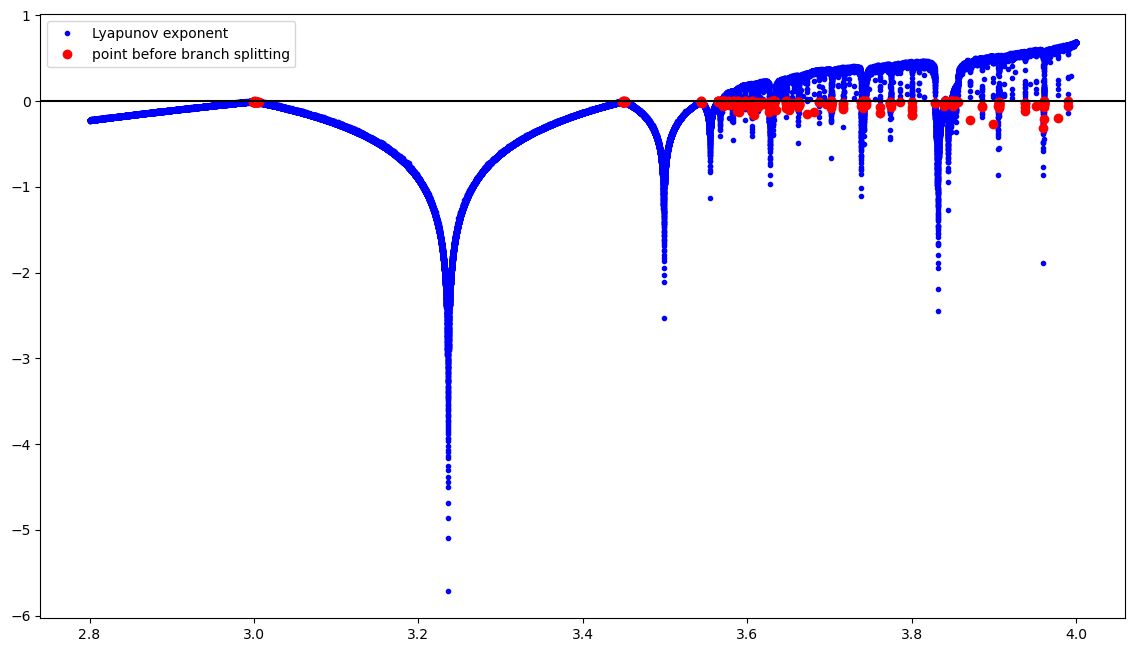

In [162]:
@njit
def elements_before_positive(arr):
    before_positive = np.zeros(arr.shape)
    for i in range(len(arr) - 1):
        if arr[i] < 0 and arr[i + 1] >= 0:
            before_positive[i] = arr[i]
    return before_positive

y = elements_before_positive(L)

plt.plot(R, L, "b.", label="Lyapunov exponent")
plt.plot(R[y == L] + np.diff(R)[0], L[y == L],
         "ro", label="point before branch splitting")
plt.axhline(0, c="k")
plt.legend()

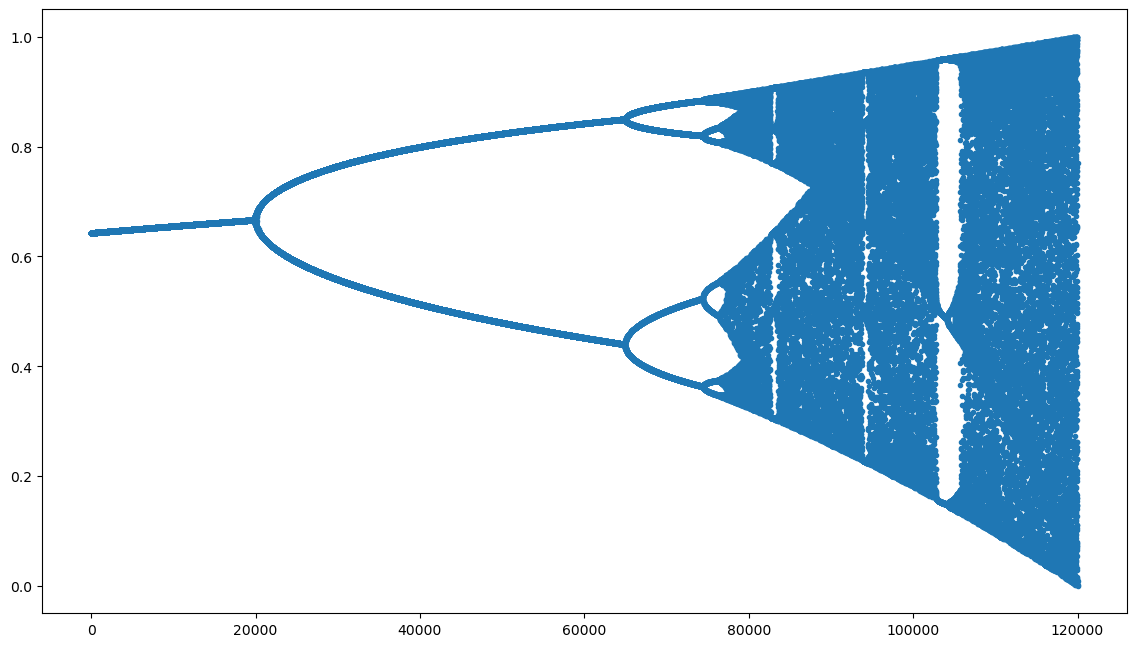

In [167]:
#alpha = (a1 - a0) / (a2 - a1)

plt.plot(lims[:,-1], ".")

# Task 3

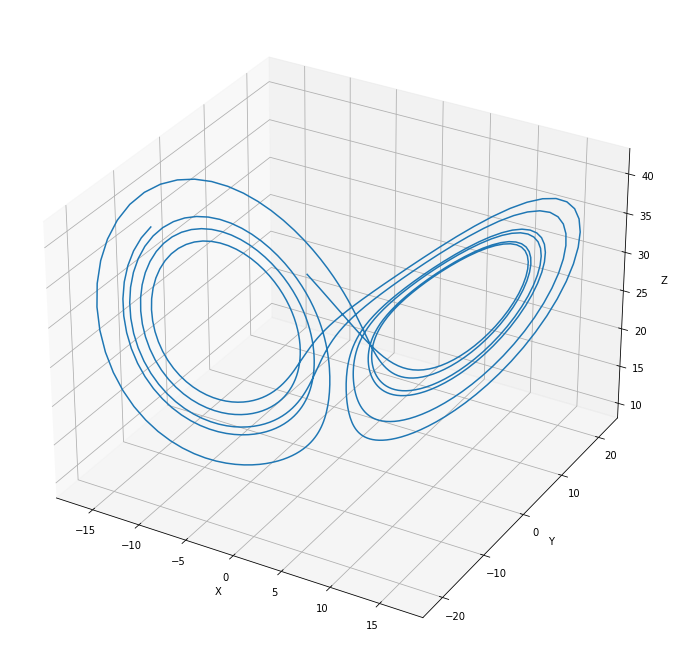

In [15]:
# plotting the solutions to the Lorentz system
def plot_array_3d(arr):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(*arr.T)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
# runge-kutta fourth-order numerical integration
@njit
def rk4(func, tk, _yk, _dt=0.01):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, _yk)
    f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)))
    f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)))
    f4 = func(tk + _dt, _yk + (f3 * _dt))

    # return an average of the derivative over tk, tk + dt
    return _yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)

@njit
def lorenz(_t, _y, sigma=10, beta=(8 / 3), rho=28):
    """
    lorenz chaotic differential equation: dy/dt = f(t, y)
    _t: time tk to evaluate system
    _y: 3D state vector [x, y, z]
    sigma: constant related to Prandtl number
    beta: geometric physical property of fluid layer
    rho: constant related to the Rayleigh number
    return: [x_dot, y_dot, z_dot]
    """
    return np.array([
        sigma * (_y[1] - _y[0]),
        _y[0] * (rho - _y[2]) - _y[1],
        (_y[0] * _y[1]) - (beta * _y[2]),
    ])

yk = np.array([-7, 8, 26])

dt = 0.01
time = np.arange(0.0, 20, dt)
state_history = []

# iterate over time
for t in time:
    state_history.append(yk)
    yk = rk4(lorenz, t, yk, dt)
    
state_history = np.array(state_history)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*state_history.T)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#plt.savefig("lorenz attractor", bbox_inches="tight")

# Task 4
1. Choose some initial condition such that it is attracted by the Lorentz system.
2. Definition of Lyapunov exponent: 
$$\lambda = \frac{1}{n}\sum_{i=0}^{n-1}\ln{\abs{f'(x_i)}}$$. What happens when $n$ becomes big? Is $\lambda$ positive or negative? What does it mean?

In [261]:
sigma = 10 
rho = 28 
beta = 8/3

yk = np.array([-7, 8, 26])

dt = 0.01
time = np.arange(0.0, 20, dt)
state_history = []
v = []

# iterate over time
for t in time:
    x, y, z = yk
    v.append(
        [sigma*(y-x), x*(rho-z) - y, x*y - beta*z]
    )
    
    state_history.append(yk)
    yk = rk4(lorenz, t, yk, dt)

    
state_history = np.array(state_history)
v = np.array(v)
Lyapunov_exponents = np.log(np.abs(v)).mean(0)
print(Lyapunov_exponents, "for x, y, z")

[3.2418655  3.26999055 3.85881722] for x, y, z


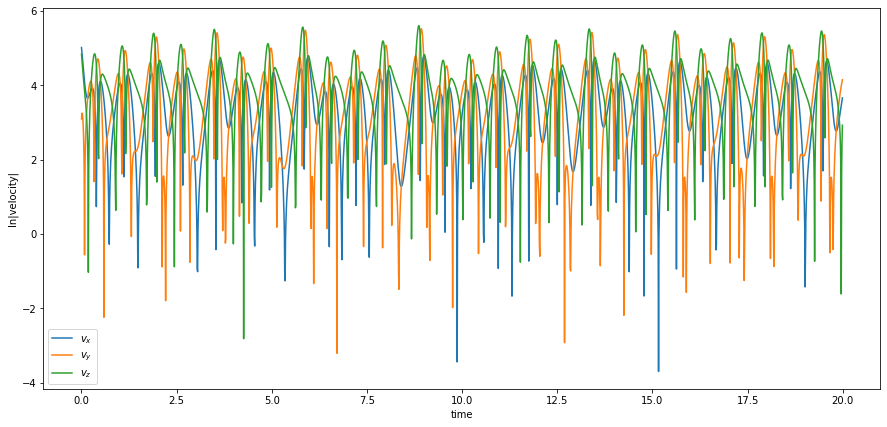

In [270]:
plt.plot(time, np.log(np.abs(v))[:,0], label="$v_x$")
plt.plot(time, np.log(np.abs(v))[:,1], label="$v_y$")
plt.plot(time, np.log(np.abs(v))[:,2], label="$v_z$")

plt.xlabel("time")
plt.ylabel("ln|velocity|")
plt.legend()
plt.savefig("log_abs_J", bbox_inches="tight")